In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import copy

In [65]:
altitude = 121.92
fov = 100
angle = fov/2
width_multiplier = 2 * np.tan(np.radians(angle))
height_multiplier = (3 * width_multiplier)/4

In [66]:
image_path = "map_sq.png"
map_img = cv2.imread(image_path)
img_sz = map_img.shape[0]
map_sz = 1200
resolution = img_sz/map_sz

In [67]:
def state_to_pixel(state):
    predicted_x, predicted_y = state
    predicted_x_px = int((img_sz/2) + (resolution * predicted_x))
    predicted_y_px = int((img_sz/2) + (resolution * predicted_y))
    return predicted_x_px, predicted_y_px

In [68]:
def generate_predicted_image(state, img):
    # Generate predicted image based on particle state
    predicted_x_px, predicted_y_px = state_to_pixel(state)
    img_width = (altitude * width_multiplier)
    img_height = (altitude * height_multiplier)
    if img_width>0:
        return cv2.rotate(img[predicted_x_px-int(img_width/2):predicted_x_px+int(img_width/2),
                   predicted_y_px-int(img_height/2):predicted_y_px+int(img_height/2)], cv2.ROTATE_90_COUNTERCLOCKWISE)   # Assuming a 100x100 crop
    else:
        return None

In [69]:
test = generate_predicted_image((0,0), map_img)

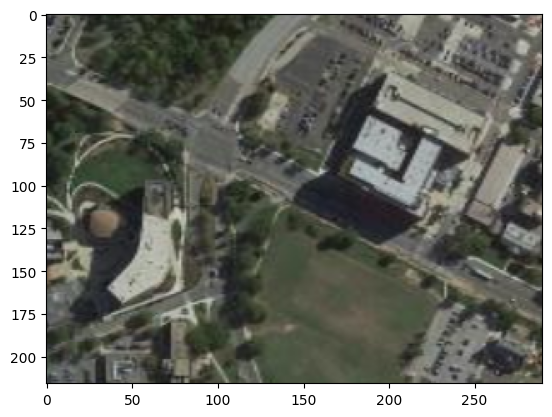

In [70]:
test1 = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test1)
plt.show()

In [74]:
from numpy.random import uniform, randn
import scipy

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 2))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    # particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    # particles[:, 2] %= 2 * np.pi
    return particles

In [75]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [76]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:1] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [ ]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:1]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var